# Paper ST Sloping - 4 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 16

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_4beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,...,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205,0.019933,NSR
1,e0106,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,...,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608,-0.009617,NSR
2,e0106,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,...,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476,-0.011823,NSR
3,e0106,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,...,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491,-0.021803,NSR
4,e0106,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,...,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661,0.007397,NSR


In [5]:
data['label'].value_counts()

NSR    104876
ST-     21993
ST+      9879
Name: label, dtype: int64

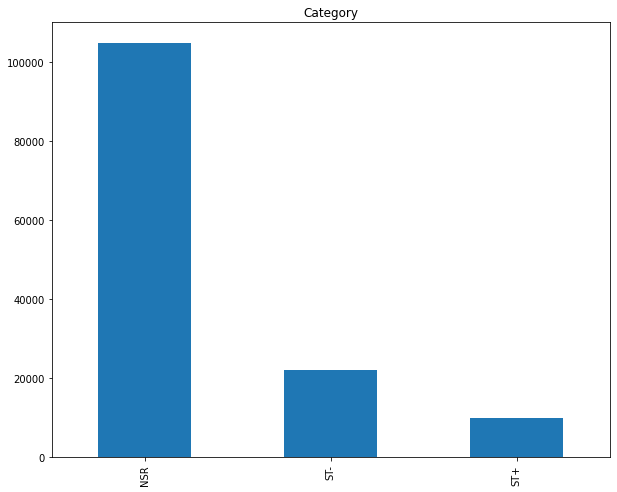

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.312273,0.162467,0.110289,0.114818,0.091114,-0.029557,0.006399,-0.000875,0.001703,...,-0.042191,-0.050062,-0.008514,0.005894,0.015042,-0.023458,-0.014237,-0.036773,-0.059384,-0.038783
dw_2,0.312273,1.000000,0.840060,0.440370,0.158646,0.415202,-0.437598,-0.206089,-0.003727,0.005025,...,-0.143619,0.102186,0.218697,0.162054,0.045198,0.025353,0.101591,-0.013728,-0.121356,-0.078300
dw_3,0.162467,0.840060,1.000000,0.613108,0.233954,0.305744,-0.499972,-0.269989,-0.004282,0.002581,...,-0.201584,0.090697,0.252037,0.115305,-0.043451,0.034627,0.045318,-0.033912,-0.133216,-0.044818
dw_4,0.110289,0.440370,0.613108,1.000000,0.900298,0.029004,-0.221348,-0.125818,-0.001509,0.000622,...,-0.139370,0.027890,0.115591,0.036784,-0.040897,0.031590,0.027101,-0.027459,-0.083792,-0.027346
dw_5,0.114818,0.158646,0.233954,0.900298,1.000000,-0.093747,-0.013018,-0.014289,0.000039,-0.000191,...,-0.065101,-0.007436,0.022364,0.006044,-0.015060,0.013505,0.011685,-0.024332,-0.037581,-0.015057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.023458,0.025353,0.034627,0.031590,0.013505,-0.078775,0.021517,0.061659,0.000381,0.003797,...,-0.114312,-0.205332,-0.130827,-0.012334,0.047726,1.000000,-0.024143,-0.054066,-0.277308,-0.170496
cfr_13,-0.014237,0.101591,0.045318,0.027101,0.011685,0.077259,0.004550,0.003053,-0.000895,0.001937,...,0.110173,0.020152,-0.217039,-0.265132,-0.093551,-0.024143,1.000000,0.126068,0.040084,-0.170708
cfr_14,-0.036773,-0.013728,-0.033912,-0.027459,-0.024332,0.014857,0.010542,0.014576,-0.000553,0.000869,...,0.077729,0.198416,0.039598,-0.185391,-0.289586,-0.054066,0.126068,1.000000,0.090389,-0.160650
cfr_15,-0.059384,-0.121356,-0.133216,-0.083792,-0.037581,0.017184,0.080945,0.046306,0.003503,-0.004316,...,0.231845,0.160889,-0.064172,-0.148376,-0.122505,-0.277308,0.040084,0.090389,1.000000,0.127273


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_165', 'fft_138', 'mfw_10', 'fft_231', 'mfw_9', 'fft_210', 'fft_252', 'fft_238', 'fft_135', 'fft_157', 'fft_189', 'fft_144', 'fft_243', 'fft_131', 'fft_235', 'fft_188', 'fft_156', 'fft_237', 'fft_175', 'mfw_11', 'fft_130', 'fft_133', 'fft_137', 'fft_207', 'fft_199', 'fft_140', 'fft_255', 'fft_196', 'fft_240', 'mfw_15', 'fft_203', 'fft_233', 'fft_225', 'fft_230', 'mfw_6', 'fft_148', 'fft_139', 'fft_151', 'fft_169', 'fft_193', 'cfr_16', 'fft_220', 'fft_143', 'fft_232', 'fft_146', 'fft_198', 'fft_245', 'fft_166', 'fft_205', 'mfw_8', 'fft_142', 'fft_223', 'fft_178', 'fft_208', 'fft_152', 'fft_170', 'fft_250', 'fft_194', 'fft_253', 'fft_201', 'fft_222', 'fft_183', 'fft_145', 'fft_218', 'fft_153', 'fft_180', 'fft_229', 'fft_216', 'fft_200', 'fft_244', 'fft_202', 'fft_186', 'fft_217', 'fft_150', 'fft_132', 'fft_248', 'fft_159', 'fft_168', 'fft_164', 'fft_134', 'fft_179', 'fft_209', 'fft_228', 'fft_182', 'fft_167', 'fft_158', 'fft_163', 'fft_224', 'mfw_14', 'fft_141', 'fft_155', 'fft_177'

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=16, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 74


### Visualization best features

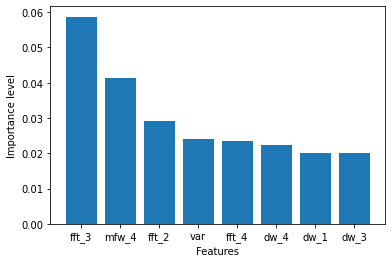

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,0.294201,...,-0.013426,0.064171,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205
1,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,-1.533708,...,0.016671,0.036579,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608
2,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,-0.720965,...,0.020868,0.035213,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476
3,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,0.838703,...,0.026449,0.028665,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491
4,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,-0.600837,...,-0.015116,0.060441,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST-']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 32.145618200302124 s
Tot: Accuracy 0.9375502742230347 Precision 0.938133778839964 Recall 0.9375502742230347 Specificity 0.9011627474210314 F1 0.9377074274557284
NSR: Accuracy 0.9380621572212066 Precision 0.9629381023157693 Recall 0.9561532968340871 Specificity 0.8781717888100867 F1 0.959533705986336
ST+: Accuracy 0.9841681901279707 Precision 0.8553191489361702 Recall 0.934400826446281 Specificity 0.9879593924608484 F1 0.8931128116514441
ST-: Accuracy 0.9528702010968921 precision 0.8563270899954317 Recall 0.8503061918802449 Specificity 0.9725818403731311 F1 0.8533060202571982
#---------------------#
#---------------------#
2 of 1000 - 31.887999773025513 s
Tot: Accuracy 0.9377330895795247 Precision 0.9389019048777881 Recall 0.9377330895795247 Specificity 0.9088899106485642 F1 0.9381531113787503
NSR: Accuracy 0.9382449725776966 Precision 0.9661621517400945 Recall 0.9530692786838476 Specificity 0.8889064725431239 F1 0.9595710558441246
ST+: Accuracy 0.984

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.937550,0.938134,0.937550,0.901163,0.937707,0.938062,0.962938,0.956153,0.878172,0.959534,0.984168,0.855319,0.934401,0.987959,0.893113,0.952870,0.856327,0.850306,0.972582,0.853306
1,0.937733,0.938902,0.937733,0.908890,0.938153,0.938245,0.966162,0.953069,0.888906,0.959571,0.984388,0.862944,0.935000,0.988284,0.897528,0.952834,0.841334,0.864320,0.969433,0.852672
2,0.934735,0.935620,0.934735,0.900048,0.935039,0.935064,0.962792,0.952354,0.877532,0.957544,0.984717,0.863256,0.937374,0.988412,0.898789,0.949689,0.836971,0.848157,0.968840,0.842527
3,0.935759,0.936457,0.935759,0.900657,0.935978,0.936124,0.962418,0.953925,0.877663,0.958153,0.984095,0.859899,0.935065,0.987967,0.895908,0.951298,0.847222,0.849156,0.970785,0.848188
4,0.932980,0.934359,0.932980,0.901621,0.933447,0.933638,0.963452,0.949760,0.879892,0.956557,0.982011,0.837316,0.929592,0.986058,0.881044,0.950311,0.837393,0.853367,0.968651,0.845304
5,0.935247,0.936049,0.935247,0.899752,0.935485,0.935649,0.962256,0.953545,0.876611,0.957881,0.983291,0.846910,0.932955,0.987132,0.887853,0.951554,0.850770,0.849423,0.971257,0.850096
6,0.934442,0.935196,0.934442,0.900249,0.934656,0.934991,0.961882,0.952779,0.877081,0.957309,0.983985,0.857716,0.941724,0.987395,0.897759,0.949909,0.843943,0.843558,0.970216,0.843750
7,0.936929,0.937830,0.936929,0.906153,0.937213,0.937294,0.964243,0.953416,0.884735,0.958799,0.984644,0.862022,0.944362,0.987875,0.901316,0.951920,0.846953,0.854864,0.970472,0.850890
8,0.936746,0.937926,0.936746,0.905465,0.937126,0.937112,0.965211,0.952758,0.884474,0.958944,0.983071,0.846778,0.938561,0.986587,0.890310,0.953309,0.845833,0.856741,0.971150,0.851252
9,0.935101,0.935668,0.935101,0.897784,0.935293,0.935430,0.961259,0.954196,0.873885,0.957715,0.983693,0.861228,0.924509,0.988329,0.891748,0.951079,0.847461,0.849001,0.970670,0.848230


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_4beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9351683729433273
Precision 0.9359657177123543
Recall 0.9351683729433273
Specificity 0.9003529869905549
F1 0.9354083784221259
######## NSR ########
Accuracy 0.9355965630712981
Precision 0.9623570583634974
Recall 0.9532990939770093
Specificity 0.8773912487809542
F1 0.9578055891402398
######## ST+ ########
Accuracy 0.9837948811700182
Precision 0.8536554023988709
Recall 0.9360906051228072
Specificity 0.987508089292249
F1 0.8929504789235997
######## ST- ########
Accuracy 0.9509453016453382
Precision 0.8471249192960064
Recall 0.8484026278439455
Specificity 0.9706220218606789
F1 0.8477465997322922
